# Databricks ML: Model Training

This notebook will covers:
- Part 1: Training a simple classification model with MLflow tracking
- Part 2: Hyperparameter tuning a better performing model with Hyperopt


### Requirements
- I tested the notebook over Cluster running Databricks Runtime 12.52 LTS ML.

### Libraries
Import the necessary libraries. These libraries are preinstalled on Databricks Runtime for Machine Learning ([AWS](https://docs.databricks.com/runtime/mlruntime.html)|[Azure](https://docs.microsoft.com/azure/databricks/runtime/mlruntime)|[GCP](https://docs.gcp.databricks.com/runtime/mlruntime.html)) clusters and are tuned for compatibility and performance.

In [ ]:
import mlflow
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

### Load data
The notebook uses a dataset describing different wine samples. The [dataset](https://archive.ics.uci.edu/ml/datasets/Wine) is from the UCI Machine Learning Repository.
The goal is to classify red and white wines by their quality. 


In [ ]:
# Load and preprocess data
white_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-white.csv", sep=';')
red_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-red.csv", sep=';')
white_wine['is_red'] = 0.0
red_wine['is_red'] = 1.0
data_df = pd.concat([white_wine, red_wine], axis=0)

# Define classification labels based on the wine quality
data_labels = data_df['quality'] >= 7
data_df = data_df.drop(['quality'], axis=1)

# Split 80/20 train-test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  data_df,
  data_labels,
  test_size=0.2,
  random_state=1
)

## Part 1. Train a classification model

### MLflow Tracking
[MLflow tracking](https://www.mlflow.org/docs/latest/tracking.html) allows me to organize my machine learning training code, parameters, and models. 

I can also enable automatic MLflow tracking by using [*autologging*](https://www.mlflow.org/docs/latest/tracking.html#automatic-logging).

In [ ]:
# Enable MLflow autologging for this notebook
mlflow.autolog()

2023/05/08 07:21:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/08 07:21:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/05/08 07:21:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


Next, lets train a classifier within the context of an MLflow run, which automatically logs the trained model and many associated metrics and parameters. 

supplement the logging with additional metrics such as the model's AUC score on the test dataset.

In [ ]:
with mlflow.start_run(run_name='gradient_boost') as run:
  model = sklearn.ensemble.GradientBoostingClassifier(random_state=0)
  
  # Models, parameters, and training metrics are tracked automatically
  model.fit(X_train, y_train)

  predicted_probs = model.predict_proba(X_test)
  roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
  
  # The AUC score on test data is not automatically logged, so log it manually
  mlflow.log_metric("test_auc", roc_auc)
  print("Test AUC of: {}".format(roc_auc))

Test AUC of: 0.8834365701533531


lets train another model with different hyperparameters.

In [ ]:
# Start a new run and assign a run_name for future reference
with mlflow.start_run(run_name='gradient_boost') as run:
  model_2 = sklearn.ensemble.GradientBoostingClassifier(
    random_state=0, 
    
    # Try a new parameter setting for n_estimators
    n_estimators=200,
  )
  model_2.fit(X_train, y_train)

  predicted_probs = model_2.predict_proba(X_test)
  roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
  mlflow.log_metric("test_auc", roc_auc)
  print("Test AUC of: {}".format(roc_auc))

Test AUC of: 0.8914761673151751


### View MLflow runs
Click the **Experiment** icon at the upper right of the databricks notebook to display the experiment sidebar. If necessary, click the refresh icon to fetch and monitor the latest runs. 


### Load models
We'll access the results for a specific run using the MLflow API. The code in the following cell illustrates how to load the model trained in a given MLflow run and use it to make predictions.

In [ ]:
# After a model has been logged,  load it in different notebooks or jobs
# mlflow.pyfunc.load_model makes model prediction available under a common API
model_loaded = mlflow.pyfunc.load_model(
  'runs:/{run_id}/model'.format(
    run_id=run.info.run_id
  )
)

predictions_loaded = model_loaded.predict(X_test)
predictions_original = model_2.predict(X_test)

# The loaded model should match the original
assert(np.array_equal(predictions_loaded, predictions_original))

## Part 2. Hyperparameter Tuning
Perform  sophisticated tuning using Hyperopt.

### Parallel training with Hyperopt and SparkTrials
[Hyperopt](http://hyperopt.github.io/hyperopt/) is a Python library for hyperparameter tuning. 


We'll use Hyperopt with SparkTrials to run hyperparameter sweeps and train multiple models in parallel. This reduces the time required to optimize model performance. MLflow tracking is integrated with Hyperopt to automatically log models and parameters.

In [ ]:
# Define the search space to explore
search_space = {
  'n_estimators': scope.int(hp.quniform('n_estimators', 20, 1000, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
}

def train_model(params):
  # Enable autologging on each worker
  mlflow.autolog()
  with mlflow.start_run(nested=True):
    model_hp = sklearn.ensemble.GradientBoostingClassifier(
      random_state=0,
      **params
    )
    model_hp.fit(X_train, y_train)
    predicted_probs = model_hp.predict_proba(X_test)
    # Tune based on the test AUC
    # In production settings, you could use a separate validation set instead
    roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
    mlflow.log_metric('test_auc', roc_auc)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*roc_auc}

# SparkTrials distributes the tuning using Spark workers
# Greater parallelism speeds processing, but each hyperparameter trial has less information from other trials
# On smaller clusters or Databricks Community Edition try setting parallelism=2
spark_trials = SparkTrials(
  parallelism=8
)

with mlflow.start_run(run_name='gb_hyperopt') as run:
  # Use hyperopt to find the parameters yielding the highest AUC
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=32,
    trials=spark_trials)

Hyperopt with SparkTrials will automatically track trials in MLflow.


100%|██████████| 32/32 [03:04<00:00,  5.76s/trial, best loss: -0.9167930304417486]

Total Trials: 32: 32 succeeded, 0 failed, 0 cancelled.


### Search runs to retrieve the best model
Because all of the runs are tracked by MLflow, we'll  retrieve the metrics and parameters for the best run using the MLflow search runs API to find the tuning run with the highest test auc.

This tuned model should perform better than the simpler models trained in Part 1.

In [ ]:
# Sort runs by their test auc; in case of ties, use the most recent run
best_run = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
).iloc[0]
print('Best Run')
print('AUC: {}'.format(best_run["metrics.test_auc"]))
print('Num Estimators: {}'.format(best_run["params.n_estimators"]))
print('Max Depth: {}'.format(best_run["params.max_depth"]))
print('Learning Rate: {}'.format(best_run["params.learning_rate"]))

best_model_pyfunc = mlflow.pyfunc.load_model(
  'runs:/{run_id}/model'.format(
    run_id=best_run.run_id
  )
)
best_model_predictions = best_model_pyfunc.predict(X_test[:5])
print("Test Predictions: {}".format(best_model_predictions))

Best Run
AUC: 0.9167930304417486
Num Estimators: 314.0
Max Depth: 5.0
Learning Rate: 0.15998275981285656
Test Predictions: [False False False  True False]


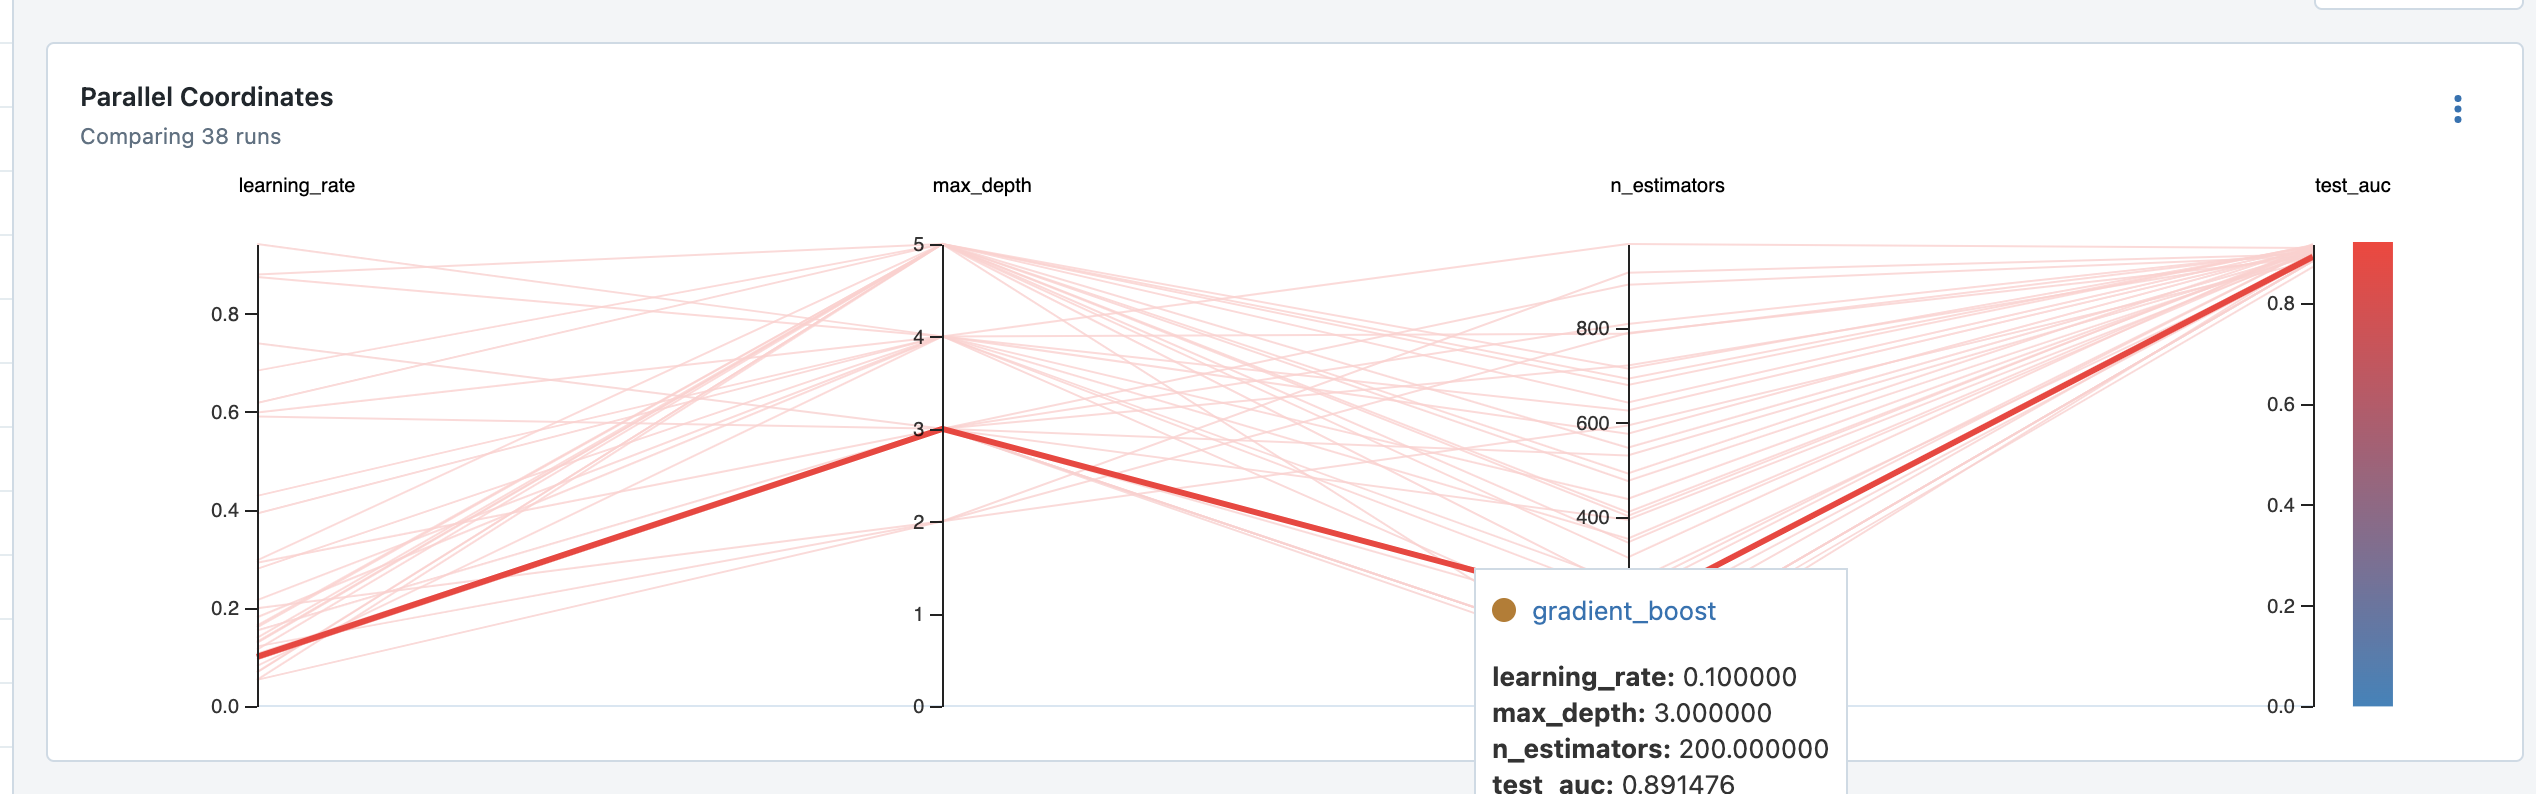